In [60]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/skidos-data/subscription_information.csv


# **PART A: INTRODUCTION**
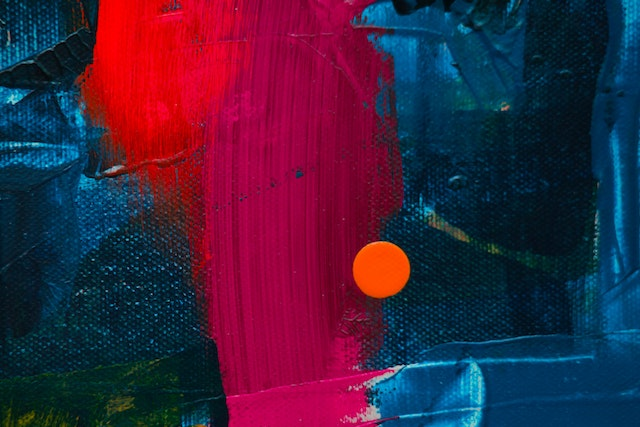

The assignment emphasises **exploratory data analysis (EDA)** using **Python** on the **SKIDOS** subscription dataset. The data corresponds to the details of the subscription bought by SKIDOS users from **Jan 1, 2022** to **Jun 30, 2022**.

The tasks to perform while analysing the data are as follows.

1. Calculate **new trials** during the month of **Jan 2022**.
2. Calculate **new subscriptions** during the month of **Jan 2022**.
3. Calculate the **trials to subscriptions** during the same month. . Express the result as a **percentage** rounded off to 2 decimal points.
4. Calculate the **number of reactivations** during the month of **Feb 2022**.
5. Calculate the **retention** of subscribers **MoM** (month over month) and **WoW** (week over week).
6. Looking at the retention, what would you **infer about the current state of the business**? How would you go about **improving** the same?
7. Find **Top-5 products** for trials & subscription **MoM** (month over month) 

# **PART B: ENVIRONMENT SETUP**
Let's start off with the necessary libraries.

- **NumPy** for mathematical operations
- **Pandas** to maintain and manipulate the data structure
- **DateTime** for manipulating date and time object data
- **Plotly** to create interactive plots

In [61]:
import numpy as np
import pandas as pd
import datetime as dt
import plotly.express as px
import plotly.graph_objects as go

pd.set_option('display.max_columns', None)

# **PART C: DATA VALIDATION**
It's time to load the dataset and have a first look at it.

In [62]:
df = pd.read_csv('/kaggle/input/skidos-data/subscription_information.csv')

In [63]:
df.head()

,Id,IdUser,IdProduct,OSVersion,ExpireDate,SubscriptionDate
0,1526897,1436744,18,IOS,2022-02-01 00:01:15,2022-01-01 00:01:15
1,1526900,491268,18,IOS,2022-02-01 00:06:23,2022-01-01 00:06:23
2,1648506,2019640,216,IOS,2022-01-01 01:06:35,2022-01-01 00:06:35
3,1565450,1665410,323,IOS,2022-02-01 00:07:16,2022-01-01 00:07:16
4,1526902,1245128,323,IOS,2022-02-01 00:15:08,2022-01-01 00:15:08


In [64]:
df.tail()

,Id,IdUser,IdProduct,OSVersion,ExpireDate,SubscriptionDate
248342,1750510,2362193,362,IOS,2022-07-03 23:52:59,2022-06-30 23:52:59
248343,1750187,2017305,461,IOS,2022-09-30 23:53:23,2022-06-30 23:53:23
248344,1750196,728278,323,IOS,2022-07-31 23:55:07,2022-06-30 23:55:07
248345,1750195,1524428,362,IOS,2022-07-31 23:55:42,2022-06-30 23:55:42
248346,1750194,1806898,18,IOS,2022-07-30 23:56:20,2022-06-30 23:56:20


The definitions of the column names in the dataset are as follows.
- **Id** - Unique identifier for the row in the csv file.
- **IdUser** - Unique identifier of the user who has bought the subscription.
- **IdProduct** - Unique identifier of the product for which the user has bought the subscription.
- **OSVersion** - platforms (Web, iOS, Android)
- **ExpireDate** - Date on which the subscription expires.
- **SubscriptionDate** - Date of purchase of subscription.

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248347 entries, 0 to 248346
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Id                248347 non-null  int64 
 1   IdUser            248347 non-null  int64 
 2   IdProduct         248347 non-null  int64 
 3   OSVersion         248347 non-null  object
 4   ExpireDate        248347 non-null  object
 5   SubscriptionDate  248347 non-null  object
dtypes: int64(3), object(3)
memory usage: 11.4+ MB


In [66]:
df.isna().sum()

Id                  0
IdUser              0
IdProduct           0
OSVersion           0
ExpireDate          0
SubscriptionDate    0
dtype: int64

In [67]:
print(df.nunique())

Id                  248347
IdUser               54239
IdProduct              237
OSVersion                3
ExpireDate          151737
SubscriptionDate    151625
dtype: int64


## **OBSERVATION:**

1. There are no null values in the entire dataset.
2. The dataset has **248347 rows**.
3. The unique count of **Id** is also **248347**. Hence, we can conclude that the **Id is unique** for each row.
4. The **total number of unique users** is **54239**. Hence, a user must have multiple trials or subscriptions in their journeys.
5. The data represents **237** types of **IdProduct** and **3** types of **OSVersion**
6. Only **integer** and **object** values are initially present.
7. The **SubscriptionDate** and **ExpireDate** are of the type **object** but contain **DateTime** information. Therefore, we'll transform them before performing DateTime operations.

# **D. EXPLORATORY DATA ANALYSIS (EDA)**

Let's unpack the data and figure out the hidden patterns. But before drawing the analysis on the time axis, we must convert the **ExpireDate** and the **SubscriptionDate** from the object to DateTime.


In [68]:
df['ExpireDate'] = pd.to_datetime(df['ExpireDate'], errors='coerce')
df['SubscriptionDate'] = pd.to_datetime(df['SubscriptionDate'], errors='coerce')

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248347 entries, 0 to 248346
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Id                248347 non-null  int64         
 1   IdUser            248347 non-null  int64         
 2   IdProduct         248347 non-null  int64         
 3   OSVersion         248347 non-null  object        
 4   ExpireDate        248347 non-null  datetime64[ns]
 5   SubscriptionDate  248347 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 11.4+ MB


The **Lifetime** denotes the difference in days between ExpireDate and SubscriptionDate. We can calculate the LifeTime by **subtracting** the SubscriptionDate from ExpireDate. The **DateTime** library will enable us to get the values in the number of days.

We'll extract a new column **SubscriptionMonth** using the **SubscriptionDate** to evaluate features for every month.

In [70]:
df['LifeTime'] = (df['ExpireDate'] - df['SubscriptionDate']).dt.total_seconds() / 60 / 60 / 24
df['SubscriptionMonth'] = pd.DatetimeIndex(df['SubscriptionDate']).month

In [71]:
df.head()

,Id,IdUser,IdProduct,OSVersion,ExpireDate,SubscriptionDate,LifeTime,SubscriptionMonth
0,1526897,1436744,18,IOS,2022-02-01 00:01:15,2022-01-01 00:01:15,31.000000,1
1,1526900,491268,18,IOS,2022-02-01 00:06:23,2022-01-01 00:06:23,31.000000,1
2,1648506,2019640,216,IOS,2022-01-01 01:06:35,2022-01-01 00:06:35,0.041667,1
3,1565450,1665410,323,IOS,2022-02-01 00:07:16,2022-01-01 00:07:16,31.000000,1
4,1526902,1245128,323,IOS,2022-02-01 00:15:08,2022-01-01 00:15:08,31.000000,1


In [72]:
df.tail()

,Id,IdUser,IdProduct,OSVersion,ExpireDate,SubscriptionDate,LifeTime,SubscriptionMonth
248342,1750510,2362193,362,IOS,2022-07-03 23:52:59,2022-06-30 23:52:59,3.0,6
248343,1750187,2017305,461,IOS,2022-09-30 23:53:23,2022-06-30 23:53:23,92.0,6
248344,1750196,728278,323,IOS,2022-07-31 23:55:07,2022-06-30 23:55:07,31.0,6
248345,1750195,1524428,362,IOS,2022-07-31 23:55:42,2022-06-30 23:55:42,31.0,6
248346,1750194,1806898,18,IOS,2022-07-30 23:56:20,2022-06-30 23:56:20,30.0,6


It's time to pour out the creativity. Using **Plotly**, we'll plot the **number of trials and subscriptions taken every month**.

In [73]:
MonthlyTrialsSubscriptions = df.groupby(['SubscriptionMonth']).size().rename("Number of trials and subscriptions").reset_index()
MonthlyTrialsSubscriptions

,SubscriptionMonth,Number of trials and subscriptions
0,1,44424
1,2,47700
2,3,55466
3,4,37384
4,5,32681
5,6,30692


## **GRAPH 1**

In [74]:
fig = px.bar(MonthlyTrialsSubscriptions, title= "Monthly total trials and subscriptions", x="SubscriptionMonth", y="Number of trials and subscriptions", color="SubscriptionMonth", text="Number of trials and subscriptions")
fig.show()

The graph above shows that **March 2022** experienced the **maximum** number of trials and subscriptions while **June 2022** had the **minimum**.

## **Task 1: To calculate new trials during the month of Jan 2022**

A **trial** is defined as a **user** having a **LifeTime** of **at most 7 days**. 

**Step 1:** Find all the trials in Jan 2022 **TotalTrialsJan** by selecting all the rows satisfing the following two conditions **simultaneously**.
- **Jan** is the the **SubscriptionMonth** 
- **LifeTime** is **not greater than 7**

In [75]:
TotalTrialsJan = df[(df['SubscriptionMonth']==1) & (df['LifeTime'] <= 7)]
TotalTrialsJan.shape

(26381, 8)

Thus, the **total number of trials** in **Jan 2022** is **26381**. However, we're **only** concerned with the **new trials** in Jan 2022.

## **RECALL**
In **PART C: DATA VALIDATION > OBSERVATION**, we've already inferred that the total number of unique users is **54239** in his/her journey. Hence, a user may have multiple trials or subscriptions. **Sorting** the dataset with respect to **IdUser** and **SubscriptionDate** will reveal the journey of each user in **chronological order**. 

In [76]:
dfSorted = df.sort_values(['IdUser', 'SubscriptionDate'], ascending=[True, True])

In [77]:
dfSorted.head()

,Id,IdUser,IdProduct,OSVersion,ExpireDate,SubscriptionDate,LifeTime,SubscriptionMonth
41777,1560270,21528,235,IOS,2022-03-01 04:05:02,2022-01-31 04:05:02,29.000000,1
92491,1606298,21528,235,IOS,2022-03-31 03:05:02,2022-03-01 04:05:02,29.958333,3
145407,1648843,21528,235,IOS,2022-05-01 03:05:02,2022-03-31 03:05:02,31.000000,3
185119,1686396,21528,235,IOS,2022-05-31 03:05:02,2022-05-01 03:05:02,30.000000,5
217109,1717103,21528,235,IOS,2022-07-01 03:05:02,2022-05-31 03:05:02,31.000000,5


In [78]:
dfSorted.tail()

,Id,IdUser,IdProduct,OSVersion,ExpireDate,SubscriptionDate,LifeTime,SubscriptionMonth
192127,1922329,2623036,729,IOS,2022-05-05 09:43:15,2022-05-05 09:38:15,0.003472,5
192138,1922330,2623036,729,IOS,2022-05-05 09:48:15,2022-05-05 09:43:15,0.003472,5
192146,1922343,2623036,731,IOS,2022-05-05 09:58:27,2022-05-05 09:43:27,0.010417,5
192163,1922288,2623036,730,IOS,2022-05-05 10:56:35,2022-05-05 09:56:35,0.041667,5
192223,1922344,2623036,731,IOS,2022-05-05 12:01:10,2022-05-05 11:46:10,0.010417,5


**Step 2:** We can get **new trials** in Jan 2022 by **filtering out** duplicate enteries of **IdUser** from **TotalTrialsJan**.

In [79]:
NewTrialsJan = TotalTrialsJan.drop_duplicates(subset='IdUser', keep="first")
NewTrialsJan.shape

(7382, 8)

> ## **Result 1: The number of new trials in the month of Jan 2022 is 7382.**

## **Task 2: To calculate new subscriptions during the month of Jan 2022**

A **subscription** is defined as a **user** having a **LifeTime** of **at least 8 days**.

**Step 1:** Find all the subscriptions in Jan 2022 **TotalSubscriptionsJan** by selecting all the rows satisfing the following two conditions **simultaneously**.
- **Jan** is the the **SubscriptionMonth** 
- **LifeTime** is **greater than or equal to 8**

**Step 2:** We can get **new subscriptions** in Jan 2022 by **filtering out** duplicate enteries of **IdUser** from **TotalSubscriptionsJan**.

In [80]:
TotalSubscriptionsJan = df[(df['SubscriptionMonth']==1) & (df['LifeTime'] >= 8)]
NewSubscriptionsJan = TotalSubscriptionsJan.drop_duplicates(subset='IdUser', keep="first")
NewSubscriptionsJan.shape

(17494, 8)

> ## **Result 2: The number of new subscriptions in the month of Jan 2022 is 17494**

## **Task 3: To calculate Trials to Subscriptions during the month of Jan 2022**

***Formula: Trials to Subscriptions = Number of new subscriptions / Number of new trials***

To express as the result a percentage rounded off to 2 decimal places, we'll do the following.
- Multiply the division outcome by 100, and
- Use the **round()** function with 2 as the second parameter 

In [81]:
TrialsToSubscriptionsJan = round((NewSubscriptionsJan.shape[0] / NewTrialsJan.shape[0]) * 100, 2)
TrialsToSubscriptionsJan

236.98

> ## **Result 3: The Trials to Subscriptions during the month of Jan 2022 is 236.98%.**

## **Task 4: To calculate the number of reactivations during the month of Feb 2022**

A **reactivation** is defined as a **user** who has subscribed **later** than the expected renewal rate. Users are expected to renew within **1 day** of the subscription **expiry** date.

> **Important:** We must use **dfSorted** as it already contains the records sorted with respect to **IdUser** and **SubscriptionDate**. The **dfSorted** shows the journey of each user in **chronological** order.

**Step 1:** Find the gap between the renewal and expiry. This gap will be called **RenewalRate**. 

***Formula: Renewal Rate = Current SubscriptionDate - Previous ExpireDate***

To implement the Step 1, we'll generate two columns.
- **ShiftedExpireDate** by shifting the **ExpireDate** column down by 1 unit.
- **ShiftedIdUser** by shifting the **IdUser** column down by 1 unit.

In [82]:
dfSorted['ShiftedExpireDate'] = dfSorted['ExpireDate'].shift(1)
dfSorted['ShiftedIdUser'] = dfSorted['IdUser'].shift(1)

In [83]:
dfSorted.head()

,Id,IdUser,IdProduct,OSVersion,ExpireDate,SubscriptionDate,LifeTime,SubscriptionMonth,ShiftedExpireDate,ShiftedIdUser
41777,1560270,21528,235,IOS,2022-03-01 04:05:02,2022-01-31 04:05:02,29.000000,1,NaT,NaN
92491,1606298,21528,235,IOS,2022-03-31 03:05:02,2022-03-01 04:05:02,29.958333,3,2022-03-01 04:05:02,21528.0
145407,1648843,21528,235,IOS,2022-05-01 03:05:02,2022-03-31 03:05:02,31.000000,3,2022-03-31 03:05:02,21528.0
185119,1686396,21528,235,IOS,2022-05-31 03:05:02,2022-05-01 03:05:02,30.000000,5,2022-05-01 03:05:02,21528.0
217109,1717103,21528,235,IOS,2022-07-01 03:05:02,2022-05-31 03:05:02,31.000000,5,2022-05-31 03:05:02,21528.0


In [84]:
dfSorted.tail()

,Id,IdUser,IdProduct,OSVersion,ExpireDate,SubscriptionDate,LifeTime,SubscriptionMonth,ShiftedExpireDate,ShiftedIdUser
192127,1922329,2623036,729,IOS,2022-05-05 09:43:15,2022-05-05 09:38:15,0.003472,5,2022-05-05 09:38:15,2623036.0
192138,1922330,2623036,729,IOS,2022-05-05 09:48:15,2022-05-05 09:43:15,0.003472,5,2022-05-05 09:43:15,2623036.0
192146,1922343,2623036,731,IOS,2022-05-05 09:58:27,2022-05-05 09:43:27,0.010417,5,2022-05-05 09:48:15,2623036.0
192163,1922288,2623036,730,IOS,2022-05-05 10:56:35,2022-05-05 09:56:35,0.041667,5,2022-05-05 09:58:27,2623036.0
192223,1922344,2623036,731,IOS,2022-05-05 12:01:10,2022-05-05 11:46:10,0.010417,5,2022-05-05 10:56:35,2623036.0


To find the **Renewal Rate**, we'll invoke the **getRenewalRate** function. The function will return the **Renewal Rate** for each row only if the **ShiftedIdUser** matches with the **IdUser**. If the **ShiftedIdUser** and **IdUser** come from two **different** users, it'll return **NaN**.

In [85]:
def getRenewalRate(row):
    if row['IdUser'] == row['ShiftedIdUser']:
        return (row['SubscriptionDate'] - row['ShiftedExpireDate'])
    return np.nan

In [86]:
dfSorted['RenewalRate'] = dfSorted.apply(getRenewalRate, axis=1).dt.total_seconds() / 60 / 60 / 24

**The interpretation of the Renewal Rate is as follows.**
> **Renewal Rate > 1:** It implies **Reactivation**

> **Renewal Rate < 0:** It means **Renewal before ExpireDate**. It doesn't imply **Reactivation**.

> **Renewal Rate = 0:** It means **Renewal on the ExpireDate**. It doesn't imply **Reactivation** either.

In [87]:
dfSorted.head()

,Id,IdUser,IdProduct,OSVersion,ExpireDate,SubscriptionDate,LifeTime,SubscriptionMonth,ShiftedExpireDate,ShiftedIdUser,RenewalRate
41777,1560270,21528,235,IOS,2022-03-01 04:05:02,2022-01-31 04:05:02,29.000000,1,NaT,NaN,NaN
92491,1606298,21528,235,IOS,2022-03-31 03:05:02,2022-03-01 04:05:02,29.958333,3,2022-03-01 04:05:02,21528.0,0.0
145407,1648843,21528,235,IOS,2022-05-01 03:05:02,2022-03-31 03:05:02,31.000000,3,2022-03-31 03:05:02,21528.0,0.0
185119,1686396,21528,235,IOS,2022-05-31 03:05:02,2022-05-01 03:05:02,30.000000,5,2022-05-01 03:05:02,21528.0,0.0
217109,1717103,21528,235,IOS,2022-07-01 03:05:02,2022-05-31 03:05:02,31.000000,5,2022-05-31 03:05:02,21528.0,0.0


In [88]:
dfSorted.tail()

,Id,IdUser,IdProduct,OSVersion,ExpireDate,SubscriptionDate,LifeTime,SubscriptionMonth,ShiftedExpireDate,ShiftedIdUser,RenewalRate
192127,1922329,2623036,729,IOS,2022-05-05 09:43:15,2022-05-05 09:38:15,0.003472,5,2022-05-05 09:38:15,2623036.0,0.000000
192138,1922330,2623036,729,IOS,2022-05-05 09:48:15,2022-05-05 09:43:15,0.003472,5,2022-05-05 09:43:15,2623036.0,0.000000
192146,1922343,2623036,731,IOS,2022-05-05 09:58:27,2022-05-05 09:43:27,0.010417,5,2022-05-05 09:48:15,2623036.0,-0.003333
192163,1922288,2623036,730,IOS,2022-05-05 10:56:35,2022-05-05 09:56:35,0.041667,5,2022-05-05 09:58:27,2623036.0,-0.001296
192223,1922344,2623036,731,IOS,2022-05-05 12:01:10,2022-05-05 11:46:10,0.010417,5,2022-05-05 10:56:35,2623036.0,0.034433


**Step 2:** Find the number of reactivations **NumReactivations** by selecting only the rows with the **RenewalRate more than 1 day** and the **SubscriptionMonth** of **Feb**. 

In [89]:
NumReactivations = dfSorted[(dfSorted['RenewalRate'] > 1) & (dfSorted['SubscriptionMonth'] == 2)]
NumReactivations.shape

(1067, 11)

In [90]:
NumReactivations.head()

,Id,IdUser,IdProduct,OSVersion,ExpireDate,SubscriptionDate,LifeTime,SubscriptionMonth,ShiftedExpireDate,ShiftedIdUser,RenewalRate
73882,1587208,316333,77,IOS,2022-03-17 16:19:28,2022-02-17 17:19:28,27.958333,2,2022-02-09 17:56:42,316333.0,7.974144
62618,1577838,582392,318,IOS,2022-03-09 16:51:22,2022-02-09 16:51:22,28.000000,2,2022-02-08 05:06:11,582392.0,1.489711
86161,1600414,638871,118,IOS,2022-03-24 16:54:53,2022-02-24 17:54:53,27.958333,2,2022-02-04 16:30:29,638871.0,20.058611
76134,1587624,713106,471,IOS,2022-05-18 16:04:30,2022-02-18 17:04:30,88.958333,2,2022-02-03 20:07:37,713106.0,14.872836
88376,1601827,732669,129,IOS,2022-03-26 07:45:49,2022-02-26 08:45:49,27.958333,2,2022-02-13 11:38:25,732669.0,12.880139


In [91]:
NumReactivations.tail()

,Id,IdUser,IdProduct,OSVersion,ExpireDate,SubscriptionDate,LifeTime,SubscriptionMonth,ShiftedExpireDate,ShiftedIdUser,RenewalRate
57600,1897712,2565617,487,IOS,2022-02-07 12:43:36,2022-02-07 12:28:36,0.010417,2,2022-02-04 16:36:02,2565617.0,2.828171
50976,1898297,2565717,322,IOS,2022-02-03 13:26:07,2022-02-03 12:26:07,0.041667,2,2022-02-01 13:57:00,2565717.0,1.936887
57601,1898119,2565717,487,IOS,2022-02-07 12:43:36,2022-02-07 12:28:36,0.010417,2,2022-02-04 16:36:02,2565717.0,2.828171
64991,1920689,2618346,704,IOS,2022-02-11 07:31:21,2022-02-11 06:31:21,0.041667,2,2022-02-02 18:13:29,2618346.0,8.512407
69135,1920701,2618346,704,IOS,2022-02-15 10:36:52,2022-02-15 09:36:52,0.041667,2,2022-02-11 18:31:45,2618346.0,3.628553


> ## **Result 4: The number of reactivations during the month of Feb 2022 is 1067.**

## **Task 5: To calculate the retention of subscribers MoM (month over month)**

**Cohort analysis** is a type of behavioral analytics in which you take a **group of users**, and analyze their usage patterns based on their shared traits to better track and understand their actions. A **cohort** is simply a group of people with **shared** characteristics.

**Step 1:** Get the **SubscriptionDate** in its reduced form i.e. **SubscriptionDateReduced**. The function **getReducedDate** takes a **DateTime** value as the input. Since we're concerned with **MoM (month over month)** cohort analysis, the function must reduce every **DateTime** value to its **first day** of the respective month. This is necessary to form groups of people i.e. monthly **cohorts**.

For example,
- **2022-01-09 00:15:08** gets reduced to **2022-01-01**
- **2022-06-30 23:56:20** gets reduced t0 **2022-06-01**

In [92]:
def getReducedDate(myDate):
    return dt.datetime(myDate.year, myDate.month,1)

In [93]:
df['SubscriptionDateReduced'] = df['SubscriptionDate'].apply(getReducedDate)
df['CohortDate'] =  df.groupby('IdUser')['SubscriptionDateReduced'].transform('min')

The new column **SubscriptionDateReduced** is comprised of the DateTime values reduced to the first day of respective months.

**Step 2:** Using the **SubscriptionDateReduced**, generate a new column **CohortDate** containing the cohort month for each user. The cohort month is the month in which a **IdUser first appeared** in the dataset.

In [94]:
df.head()

,Id,IdUser,IdProduct,OSVersion,ExpireDate,SubscriptionDate,LifeTime,SubscriptionMonth,SubscriptionDateReduced,CohortDate
0,1526897,1436744,18,IOS,2022-02-01 00:01:15,2022-01-01 00:01:15,31.000000,1,2022-01-01,2022-01-01
1,1526900,491268,18,IOS,2022-02-01 00:06:23,2022-01-01 00:06:23,31.000000,1,2022-01-01,2022-01-01
2,1648506,2019640,216,IOS,2022-01-01 01:06:35,2022-01-01 00:06:35,0.041667,1,2022-01-01,2022-01-01
3,1565450,1665410,323,IOS,2022-02-01 00:07:16,2022-01-01 00:07:16,31.000000,1,2022-01-01,2022-01-01
4,1526902,1245128,323,IOS,2022-02-01 00:15:08,2022-01-01 00:15:08,31.000000,1,2022-01-01,2022-01-01


In [95]:
df.tail()

,Id,IdUser,IdProduct,OSVersion,ExpireDate,SubscriptionDate,LifeTime,SubscriptionMonth,SubscriptionDateReduced,CohortDate
248342,1750510,2362193,362,IOS,2022-07-03 23:52:59,2022-06-30 23:52:59,3.0,6,2022-06-01,2022-06-01
248343,1750187,2017305,461,IOS,2022-09-30 23:53:23,2022-06-30 23:53:23,92.0,6,2022-06-01,2022-03-01
248344,1750196,728278,323,IOS,2022-07-31 23:55:07,2022-06-30 23:55:07,31.0,6,2022-06-01,2022-05-01
248345,1750195,1524428,362,IOS,2022-07-31 23:55:42,2022-06-30 23:55:42,31.0,6,2022-06-01,2022-01-01
248346,1750194,1806898,18,IOS,2022-07-30 23:56:20,2022-06-30 23:56:20,30.0,6,2022-06-01,2022-01-01


**Step 3:** Calculate the **CohortIndex** showing the number of months for which the platform has **retained** the users.

***Formula: Cohort Index = Year Difference * 12 + Month Difference + 1***

> **Important:** The term **'Difference**' in the formula represents the  time when a user subscribes minus the first time he/she was active on the platform. The **CohortIndex will be 1** for a user in the first month of his/her journey on the platform.

In [96]:
def getDateElements(column):
    month = column.dt.month
    year = column.dt.year
    return month, year 

In [97]:
SubscriptionMonth, SubscriptionYear =  getDateElements(df['SubscriptionDateReduced'])
CohortMonth, CohortYear =  getDateElements(df['CohortDate'])

In [98]:
YearDifference = SubscriptionYear - CohortYear
MonthDifference = SubscriptionMonth - CohortMonth
df['CohortIndex'] = YearDifference * 12 + MonthDifference + 1

In [99]:
df.head()

,Id,IdUser,IdProduct,OSVersion,ExpireDate,SubscriptionDate,LifeTime,SubscriptionMonth,SubscriptionDateReduced,CohortDate,CohortIndex
0,1526897,1436744,18,IOS,2022-02-01 00:01:15,2022-01-01 00:01:15,31.000000,1,2022-01-01,2022-01-01,1
1,1526900,491268,18,IOS,2022-02-01 00:06:23,2022-01-01 00:06:23,31.000000,1,2022-01-01,2022-01-01,1
2,1648506,2019640,216,IOS,2022-01-01 01:06:35,2022-01-01 00:06:35,0.041667,1,2022-01-01,2022-01-01,1
3,1565450,1665410,323,IOS,2022-02-01 00:07:16,2022-01-01 00:07:16,31.000000,1,2022-01-01,2022-01-01,1
4,1526902,1245128,323,IOS,2022-02-01 00:15:08,2022-01-01 00:15:08,31.000000,1,2022-01-01,2022-01-01,1


In [100]:
df.tail()

,Id,IdUser,IdProduct,OSVersion,ExpireDate,SubscriptionDate,LifeTime,SubscriptionMonth,SubscriptionDateReduced,CohortDate,CohortIndex
248342,1750510,2362193,362,IOS,2022-07-03 23:52:59,2022-06-30 23:52:59,3.0,6,2022-06-01,2022-06-01,1
248343,1750187,2017305,461,IOS,2022-09-30 23:53:23,2022-06-30 23:53:23,92.0,6,2022-06-01,2022-03-01,4
248344,1750196,728278,323,IOS,2022-07-31 23:55:07,2022-06-30 23:55:07,31.0,6,2022-06-01,2022-05-01,2
248345,1750195,1524428,362,IOS,2022-07-31 23:55:42,2022-06-30 23:55:42,31.0,6,2022-06-01,2022-01-01,6
248346,1750194,1806898,18,IOS,2022-07-30 23:56:20,2022-06-30 23:56:20,30.0,6,2022-06-01,2022-01-01,6


**Step 4:** Create the **CohortData** which stores the **count of unique IdUsers** satisfying the following two conditions simutaneously.
- **CohortDate:** The month in which the subscriber was first aquired.
- **CohortIndex:** The number of months during which the subscriber was active.
> **Important:** The third column **IdUser** in the **CohortData** table represents the **count** and not the IDs.

In [101]:
CohortData = df.groupby(['CohortDate','CohortIndex'])['IdUser'].apply(pd.Series.nunique).reset_index()
CohortData

,CohortDate,CohortIndex,IdUser
0,2022-01-01,1,21266
1,2022-01-01,2,12879
2,2022-01-01,3,11582
3,2022-01-01,4,10847
4,2022-01-01,5,9415
5,2022-01-01,6,8563
6,2022-02-01,1,7609
7,2022-02-01,2,2583
8,2022-02-01,3,1840
9,2022-02-01,4,2123


**Step 5:** Transform the **CohortData** to create a pivot table **CohortTable**. The **pivot table** will have the following properties.
- The **CohortDate** column of the **CohortData** will serve as the index in the pivot table **CohortTable**.
- The **CohortIndex** column of the **CohortData** will serve as the colum values in the pivot table **CohortTable**.
- The **IdUser** column of the **CohortData** will serve as the entries in the pivot table **CohortTable**.

In [102]:
CohortTable = CohortData.pivot(index='CohortDate', columns=['CohortIndex'],values='IdUser')
CohortTable

CohortIndex,1,2,3,4,5,6
CohortDate,,,,,,
2022-01-01,21266.0,12879.0,11582.0,10847.0,9415.0,8563.0
2022-02-01,7609.0,2583.0,1840.0,2123.0,1330.0,NaN
2022-03-01,7557.0,2348.0,1746.0,2130.0,NaN,NaN
2022-04-01,6292.0,1944.0,1506.0,NaN,NaN,NaN
2022-05-01,5631.0,1757.0,NaN,NaN,NaN,NaN
2022-06-01,5884.0,NaN,NaN,NaN,NaN,NaN


**Step 6:** Compute the **retention of subscribers MoM (month over month)**.

**SubscriberRetentionMoM** is the modifified table obtained by dividing each count in the **CohortTable** by the **initial count** of that month. 

In [103]:
SubscriberRetentionMoM = CohortTable.divide(CohortTable.iloc[:,0],axis=0)
SubscriberRetentionMoM = round(CohortTableModified * 100, 2)
SubscriberRetentionMoM

CohortIndex,1,2,3,4,5,6
CohortDate,,,,,,
2022-01-01,100.0,60.56,54.46,51.01,44.27,40.27
2022-02-01,100.0,33.95,24.18,27.90,17.48,NaN
2022-03-01,100.0,31.07,23.10,28.19,NaN,NaN
2022-04-01,100.0,30.90,23.94,NaN,NaN,NaN
2022-05-01,100.0,31.20,NaN,NaN,NaN,NaN
2022-06-01,100.0,NaN,NaN,NaN,NaN,NaN


## **GRAPH 2**
**The moment of truth:** Let's plot the **heatmap** to visualise the **Subscriber Retention Rate (%) MoM (month over month).**

In [104]:
fig = go.Figure(data=go.Heatmap(
                    z=SubscriberRetentionMoM,
                    y=SubscriberRetentionMoM.index,
                    colorscale='Greens',
                    text=SubscriberRetentionMoM,
                    texttemplate = "%{text}%",
                    colorbar_title='Retention Rate (%)',
                    xgap=3,
                    ygap=3))

fig.update_xaxes(side="top")

fig.update_layout(title="Subscriber Retention Rate (%) MoM (month over month)",
                  xaxis_title="Cohorts",
                  yaxis_title="Month",
                  
                  title_x=0.5,
                  title_y=0.99,
                  plot_bgcolor='white')
fig.show()

> ## **Result 5: Inference drawn regarding the retention of subscribers MoM (month over month)**

| OBSERVATION | NEGATIVE SIGN                                                                          |
|-------------|----------------------------------------------------------------------------------------|
| Horizontal  | Subscriber Retention drops significantly in the 2nd month.                             |
| Horizontal  | Probability of a subscriber avoiding renewal/reactivation is maximum in the 2nd month. |
| Vertical    | Subscriber Retention drops drastically Feb 2022 onwards.                               |



| OBSERVATION | POSITIVE SIGN                                                                     |
|-------------|-----------------------------------------------------------------------------------|
| Horizontal  | In the 4th month, the Subscriber Retention increases for the Feb and Mar cohorts. |
| Horizontal  | In the 4th month, the Subscriber Loss is the minimum for the Jan cohort.          |
| Horizontal  | 40.27% of the Jan cohort is subscribed even after 6 months of the relationship.   |



| Current State of the Business                                                                                                        | Ways to Improve/Enhance                                                                                                                                               |
|--------------------------------------------------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Subscriber Dissatisfaction over the company's products tends to surface in the 2nd month of the subscription.                        | Subscriber Counselling and Quality Checks to figure out the subscribers' expectations/intent                                                                          |
| The company is good at maintaining long-term relationships with subscribers.                                                         | Innovate more frequently on the product and its delivery to hold the subscribers for longer.                                                                          |
| The company is struggling to fulfil non-needy subscribers. Hence, they leave within 2 months when the product stops intriguing them. | Create an artificial need by convey to the subscribers the long-term advantages of the product.                                                                       |
| The business has the potential to regain subscribers in the 4th month.                                                               | A subscriber naturally loves to take a break before he/she can continue the product usage. Launch discounts and festive offers to tackle the subscriber's inactivity. |



## **Task 6: Find top 5 products for trials and subscription MoM (month over month)**

The top 5 product ranking will help us identify the content with the highest demand among the subscribers. We'll use the **pandas** built-in **value_counts()** and **nlargest()** functions to select top five **IdProduct** with their corresponding **frequency** in the dataframe. The frequency denotes the number of times a product was availed of in a **trial** or a **subscription**.

In [105]:
TopFiveProducts = df['IdProduct'].value_counts().nlargest(5)
TopFiveProducts

323    63714
362    49656
18     10763
487     9086
67      8838
Name: IdProduct, dtype: int64

**A trivial adjustment:** We've already fetched our top 5 products. However, to make the plotting feasible, we'll add a new column **Quantity** to the dataframe. The **Quantity** has the **default value 1** in each row indicating a **single** trial or a subscription.

In [106]:
df['Quantity'] = 1

In [107]:
df.head()

,Id,IdUser,IdProduct,OSVersion,ExpireDate,SubscriptionDate,LifeTime,SubscriptionMonth,SubscriptionDateReduced,CohortDate,CohortIndex,Quantity
0,1526897,1436744,18,IOS,2022-02-01 00:01:15,2022-01-01 00:01:15,31.000000,1,2022-01-01,2022-01-01,1,1
1,1526900,491268,18,IOS,2022-02-01 00:06:23,2022-01-01 00:06:23,31.000000,1,2022-01-01,2022-01-01,1,1
2,1648506,2019640,216,IOS,2022-01-01 01:06:35,2022-01-01 00:06:35,0.041667,1,2022-01-01,2022-01-01,1,1
3,1565450,1665410,323,IOS,2022-02-01 00:07:16,2022-01-01 00:07:16,31.000000,1,2022-01-01,2022-01-01,1,1
4,1526902,1245128,323,IOS,2022-02-01 00:15:08,2022-01-01 00:15:08,31.000000,1,2022-01-01,2022-01-01,1,1


In [108]:
df.tail()

,Id,IdUser,IdProduct,OSVersion,ExpireDate,SubscriptionDate,LifeTime,SubscriptionMonth,SubscriptionDateReduced,CohortDate,CohortIndex,Quantity
248342,1750510,2362193,362,IOS,2022-07-03 23:52:59,2022-06-30 23:52:59,3.0,6,2022-06-01,2022-06-01,1,1
248343,1750187,2017305,461,IOS,2022-09-30 23:53:23,2022-06-30 23:53:23,92.0,6,2022-06-01,2022-03-01,4,1
248344,1750196,728278,323,IOS,2022-07-31 23:55:07,2022-06-30 23:55:07,31.0,6,2022-06-01,2022-05-01,2,1
248345,1750195,1524428,362,IOS,2022-07-31 23:55:42,2022-06-30 23:55:42,31.0,6,2022-06-01,2022-01-01,6,1
248346,1750194,1806898,18,IOS,2022-07-30 23:56:20,2022-06-30 23:56:20,30.0,6,2022-06-01,2022-01-01,6,1


In [109]:
Products = df.groupby(['IdProduct'], as_index=False)['Quantity'].agg('sum')
ProductsAscending = Products.sort_values('Quantity').head(5)
ProductsAscending['Quantity'] = ProductsAscending['Quantity'] * (-1)
ProductsDescending = Products.sort_values('Quantity', ascending=False).head(5)

## **GRAPH 3**
**Can we have the drum roll please...**

## **OBSERVATION**
The top 2 products with the **IdProduct** 323 and 362 respectively are way ahead of the others.

In [110]:
fig = go.Figure(data=[
    go.Bar(name='Top 5 Products', 
           x=ProductsDescending['IdProduct'].astype(str), 
           y=ProductsDescending['Quantity'],
           marker_opacity=1,
           marker={'color': ProductsDescending['Quantity'],
                   'colorscale': 'Rainbow'})
    ])

fig.update_traces(texttemplate='%{y:.3s}', textposition='outside')
fig.update_layout(barmode='group', showlegend=False)

fig.update_layout(title='Top 5 Products',
                  title_x=0.45,
                  xaxis_title="IdProduct",
                  yaxis_title="Number Of Trials and Subscriptions",
                  plot_bgcolor='white')
fig.show()

# **E. CONCLUSION**

We've throughly churned the dataset to find the outcomes with visualisation and explaination. Let's summarise the results.
- **Result 1:** The number of **new trials** in the month of **Jan 2022** is **7382**.
- **Result 2:** The number of **new subscriptions** in the month of **Jan 2022** is **17494**.
- **Result 3:** The **Trials to Subscriptions** during the month of **Jan 2022** is **236.98%**.
- **Result 4:** The **number of reactivations** during the month of **Feb 2022** is **1067**.
- **Result 5:** **Retention** of the subscribers **MoM** (month over month) and the inference by **Cohort Analysis**.
- **Result 6:** The **top 5 products** for trials and subscription **MoM** (month over month) are:
    1. IdProduct **323**
    2. IdProduct **362**
    3. IdProduct **18**
    4. IdProduct **487**
    5. IdProduct **67**

**That's it! Thank you for reading.**

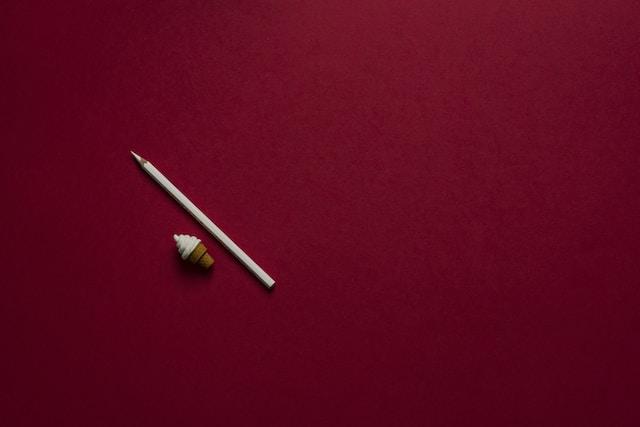
## **REFERENCES**
- [Photograph](https://www.pexels.com/photo/abstract-painting-1145720/) by [Steve Johnson](https://www.pexels.com/@steve/) on [Pexels](https://www.pexels.com/)
- [Photograph](https://unsplash.com/photos/PbgY3ptgA4A) by [Joanna Kosinska](https://unsplash.com/@joannakosinska) on [Unsplash](https://unsplash.com/)